In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

import warnings
warnings.filterwarnings('ignore')

In [15]:
def cosinus_signal_func(freq = None, T = None, init_phase = 0):
    if freq:
        w = 2 * np.pi * freq
    elif T:
        w = 2 * np.pi / T
    else:
        return None
    cos_func = lambda t: np.cos(t * w + init_phase)

    return cos_func

def rec_imp(t):
    t_r = np.floor(t)
    if t_r % 2 == 0:
        return 2
    else:
        return -2

def calc_signal(s_func, t_start = 0, t_end = None, steps_cnt = None, noised=False):
    if t_end is None:
        t_end = 2
    if steps_cnt is None:
        steps_cnt = 250

    time_series = np.linspace(t_start, t_end, steps_cnt)
    signal_vals = np.array([s_func(t) for t in time_series])
    if noised: signal_vals += np.random.normal(0, 1, signal_vals.shape)

    return signal_vals, time_series

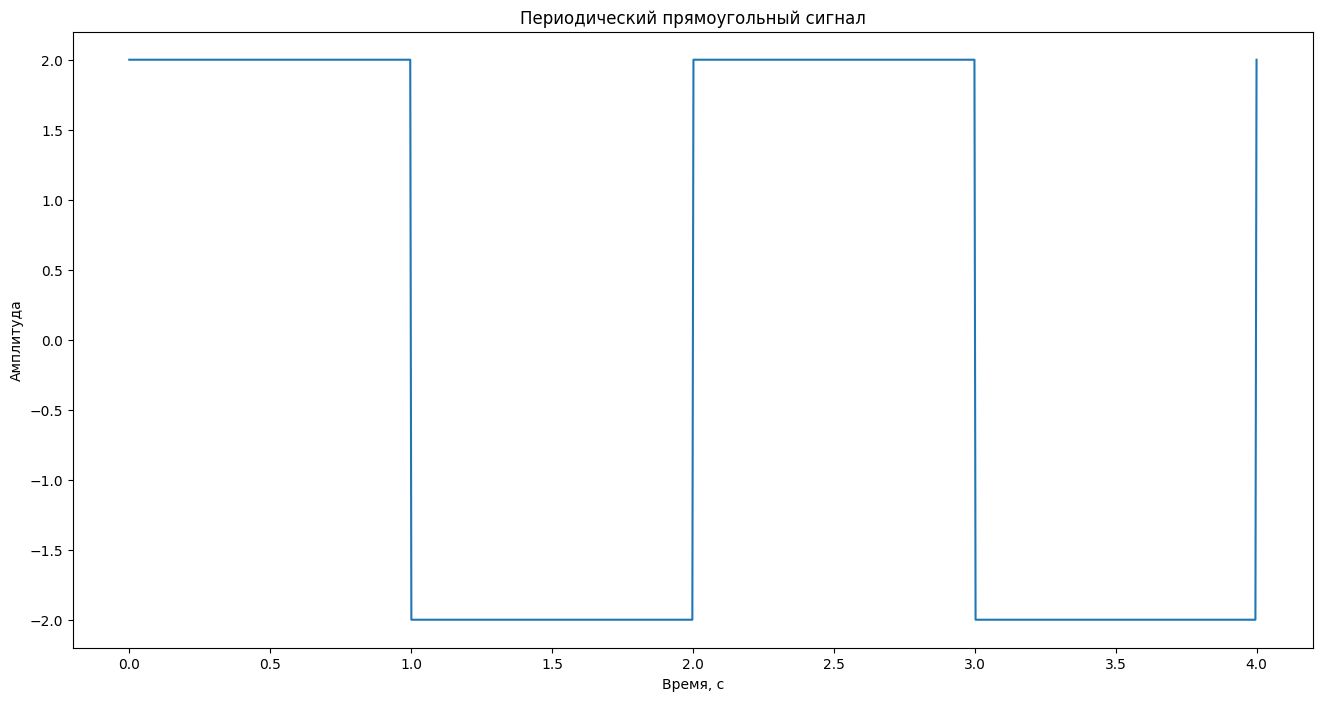

In [16]:
square_signal, square_time_series = calc_signal(rec_imp, t_end=4, steps_cnt=1000)

fig = plt.figure(figsize=(16,8))

plt.title("Периодический прямоугольный сигнал")
plt.ylabel("Амплитуда")
plt.xlabel("Время, с")
plt.plot(square_time_series, square_signal)
plt.show()

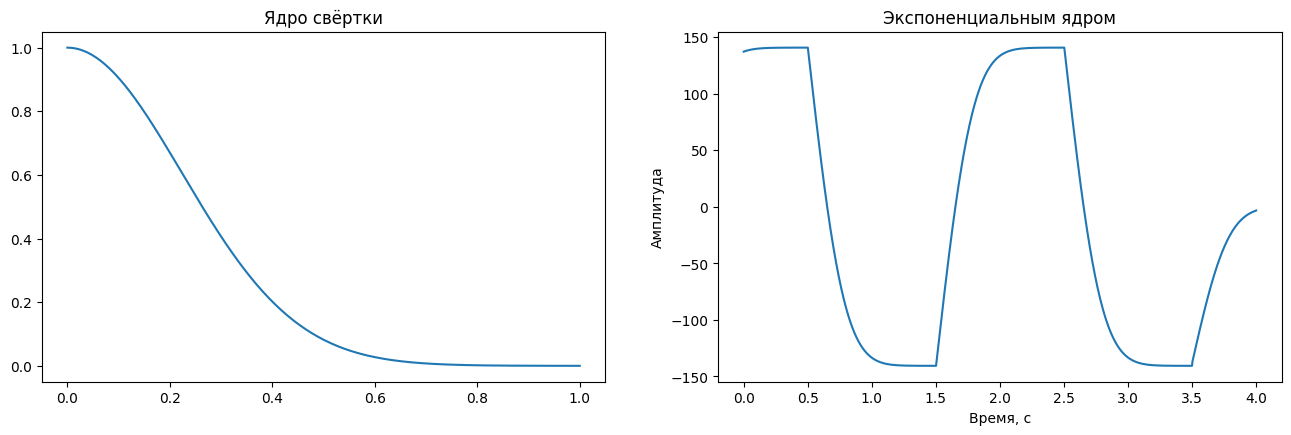

In [17]:
def kernel_exp(x, A):
    return A*np.exp(-np.power(x, 2)/0.1)

kernel_xs = np.linspace(0, 1, 250)
kernel_expo_vals = kernel_exp(kernel_xs, 1)

fig = plt.figure(figsize=(16,10))

plt.subplot(221)
plt.title("Ядро свёртки")
plt.plot(kernel_xs, kernel_expo_vals)

square_conved = np.convolve(square_signal, kernel_expo_vals, 'same')

plt.subplot(222)
plt.title("Экспоненциальным ядром")
plt.ylabel("Амплитуда")
plt.xlabel("Время, с")
plt.plot(square_time_series, square_conved)

plt.show()

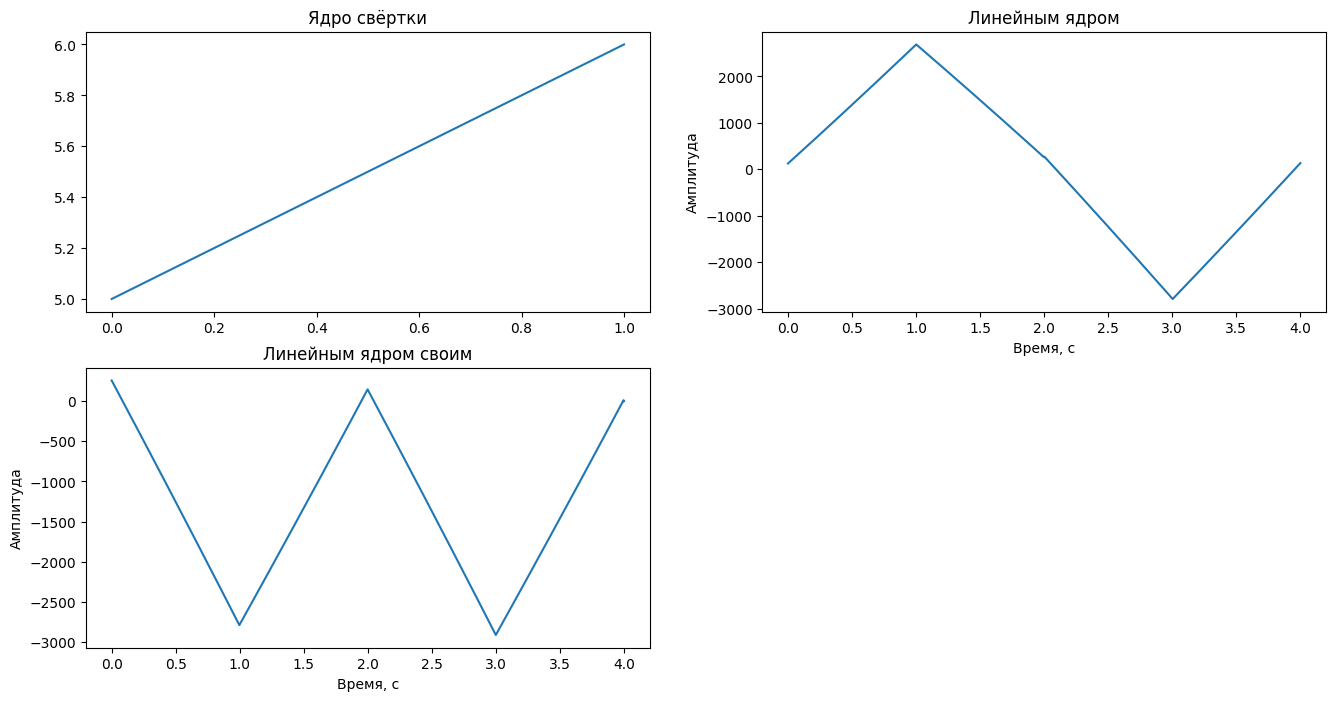

In [18]:
def kernel_linear(a, x, b):
    return a * x + b

kernel_xs = np.linspace(0, 1, 1000)
kernel_linear_vals = kernel_linear(1, kernel_xs, 5)

square_conved = np.convolve(square_signal, kernel_linear_vals, 'same')

def conv(orig, kernel):
    conv = len(orig) * [0]
    for l in range(len(orig)):
        for i in range(len(kernel)):
            try:
                conv[l] += orig[l-i+len(kernel)] * kernel[i]
            except IndexError:
                pass
    return conv


fig = plt.figure(figsize=(16,8))

plt.subplot(221)
plt.title("Ядро свёртки")
plt.plot(kernel_xs, kernel_linear_vals)

plt.subplot(222)
plt.title("Линейным ядром")
plt.ylabel("Амплитуда")
plt.xlabel("Время, с")
plt.plot(square_time_series, square_conved)

square_conved = conv(square_signal, kernel_linear_vals)

plt.subplot(223)
plt.title("Линейным ядром своим")
plt.ylabel("Амплитуда")
plt.xlabel("Время, с")
plt.plot(square_time_series, square_conved)

plt.show()

In [19]:
def extend_arr(arr, axis_0_len):
    l = list(arr)
    l_orig = l.copy()
    while len(l) < axis_0_len:
        l += l_orig
    return np.array(l)[:axis_0_len]

def fft_full(xs, ys, normalize=False):
    spectrum = np.fft.fft(ys)
    if normalize: normalize(spectrum)
    freq_series = np.fft.fftfreq(len(xs), 1/len(xs))
    return [freq_series, (spectrum)]

def normalize(arr, id=None):
    if id is None and len(arr) > 6: return arr/np.max(arr)

    arr[id] = arr[id]/np.max(arr[id])
    return arr

## Теорема о свертке

(0.0, 4.0)

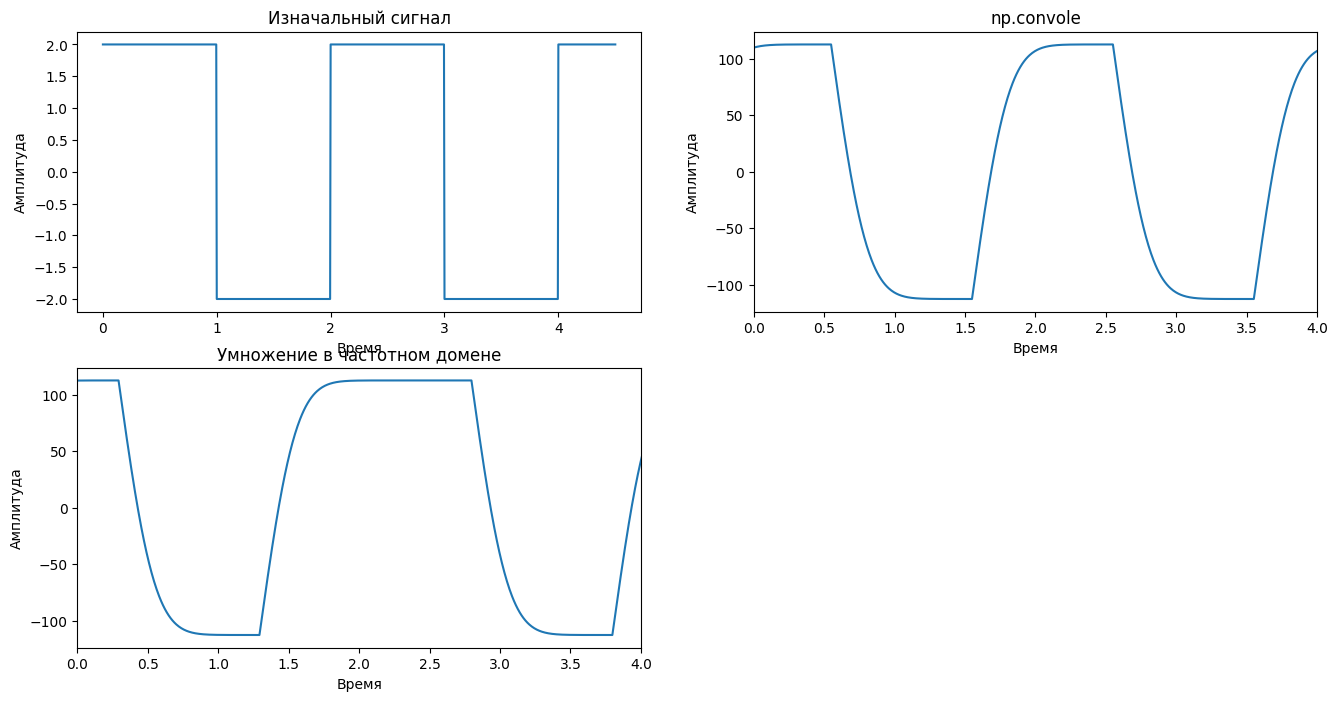

In [20]:
samples_rate = 1000

sq_vals, sq_time = calc_signal(rec_imp, t_end=4.5, steps_cnt=samples_rate)

kernel_xs = np.linspace(0, 1, 200)
kernel_expo_vals = kernel_exp(kernel_xs, 1)
kernel_expo_vals = np.pad(kernel_expo_vals, (400, 400))

cos_freqs, cos_spec = fft_full(sq_time, sq_vals) 
kernel_freqs, kernel_spec = fft_full(kernel_xs, kernel_expo_vals)

conv_fft = cos_spec * kernel_spec
conv_mlt = np.fft.ifft(conv_fft)

conved_np = np.convolve(sq_vals, kernel_expo_vals, 'same')

fig = plt.figure(figsize=(16,8))

plt.subplot(221)
plt.title("Изначальный сигнал")
plt.plot(sq_time, sq_vals)
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.subplot(222)
plt.title("np.convole")
plt.plot(sq_time, conved_np)
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.xlim([0, 4])

plt.subplot(223)
plt.title("Умножение в частотном домене")
plt.plot(sq_time, conv_mlt)
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.xlim([0, 4])


## Ядро Гаусса

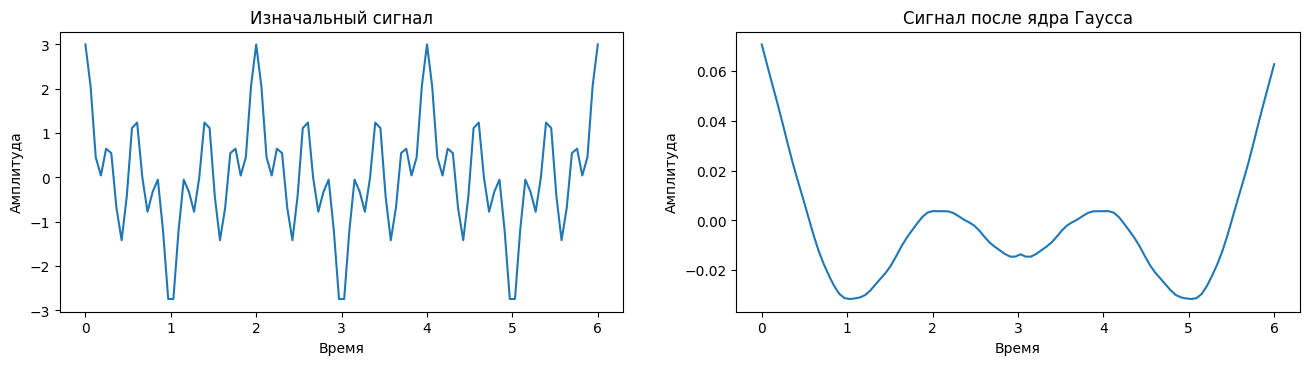

In [21]:
def gaussian_kernel(sigma, size=100):
    x = np.linspace(-3 * sigma, 3 * sigma, size)
    kernel = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x**2) / (2 * sigma**2))
    return kernel

cos_50f = cosinus_signal_func(50)
cos_150f = cosinus_signal_func(150)
cos_250f = cosinus_signal_func(350)
cos_sum = lambda t: cos_50f(t) + cos_150f(t) + cos_250f(t)

cos_sum_vals, cos_sum_time = calc_signal(cos_sum, t_end=6, steps_cnt=100)

gaussian_kernel_vals = gaussian_kernel(10)

gaussed_signal = np.convolve(cos_sum_vals, gaussian_kernel_vals, mode='same')

fig = plt.figure(figsize=(16,8))

plt.subplot(221)
plt.title("Изначальный сигнал")
plt.plot(cos_sum_time, cos_sum_vals)
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.subplot(222)
plt.title("Сигнал после ядра Гаусса")
plt.plot(cos_sum_time, gaussed_signal)
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.show()

#### Узкополосовой фильтр

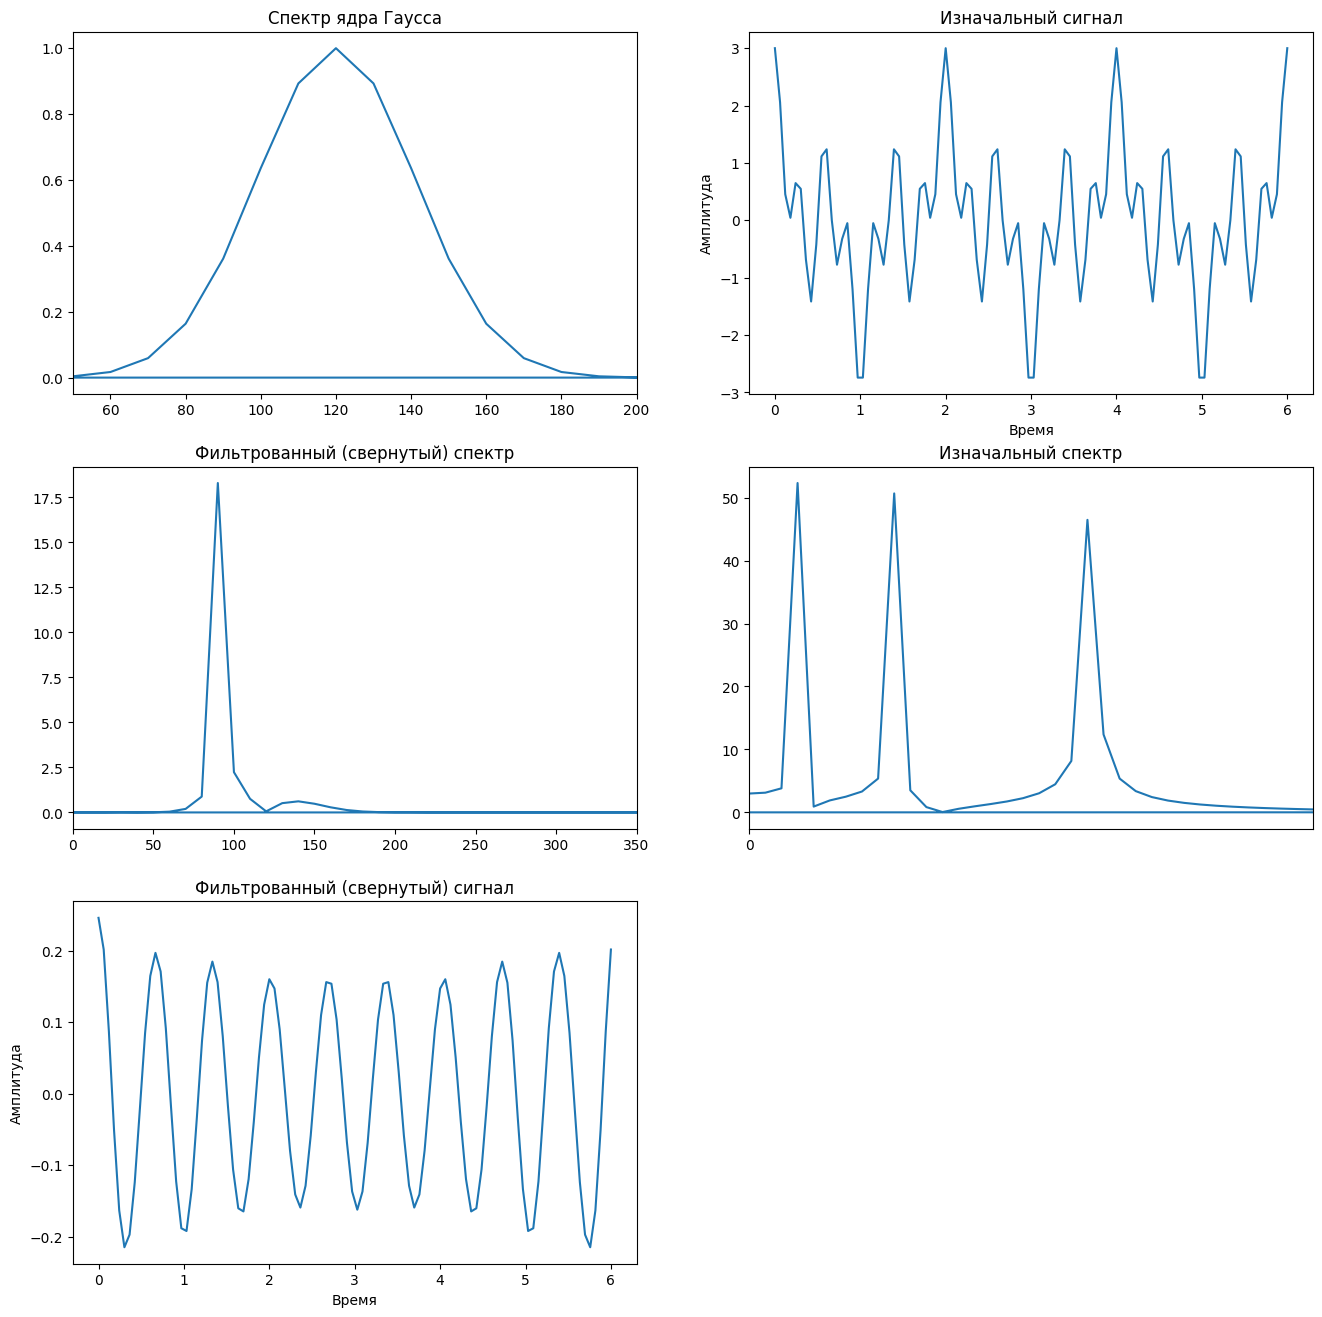

In [22]:
def gaussian_frequency_kernel(frequencies, peak_frequency, FWHM):
    s = (FWHM * (2 * np.pi - 1)) / (4 * np.pi)
    kernel = np.exp(-0.5 * ((frequencies - peak_frequency) / s) ** 2)
    return kernel

sample_rate = 1000
peak_frequency = 120 # target freq
FWHM = 50  # width

# Создаем частотный массив
frequencies = np.fft.fftfreq(len(cos_sum_time), 1.0 / sample_rate)

frequency_kernel = gaussian_frequency_kernel(frequencies, peak_frequency, FWHM)

spectrum_cos_sum = np.abs(np.fft.fft(cos_sum_vals))
conved_cos_sum = frequency_kernel * spectrum_cos_sum

plt.figure(figsize=(16, 16))

plt.subplot(321)
plt.plot(frequencies, np.abs(frequency_kernel))
plt.title('Cпектр ядра Гаусса')
plt.xlim([50, 200])

plt.subplot(322)
plt.title("Изначальный сигнал")
plt.plot(cos_sum_time, cos_sum_vals)
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.subplot(323)
plt.title("Фильтрованный (свернутый) спектр")
plt.plot(frequencies, conved_cos_sum)
plt.xlim([0, 350])

plt.subplot(324)
plt.title("Изначальный спектр")
plt.plot(frequencies, np.abs(np.fft.fft(cos_sum_vals)))
plt.xticks([0])
plt.xlim([0, 350])

plt.subplot(325)
plt.title("Фильтрованный (свернутый) сигнал")
plt.plot(cos_sum_time, np.fft.ifft(conved_cos_sum))
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.show()


#### Фильтр нижних частот

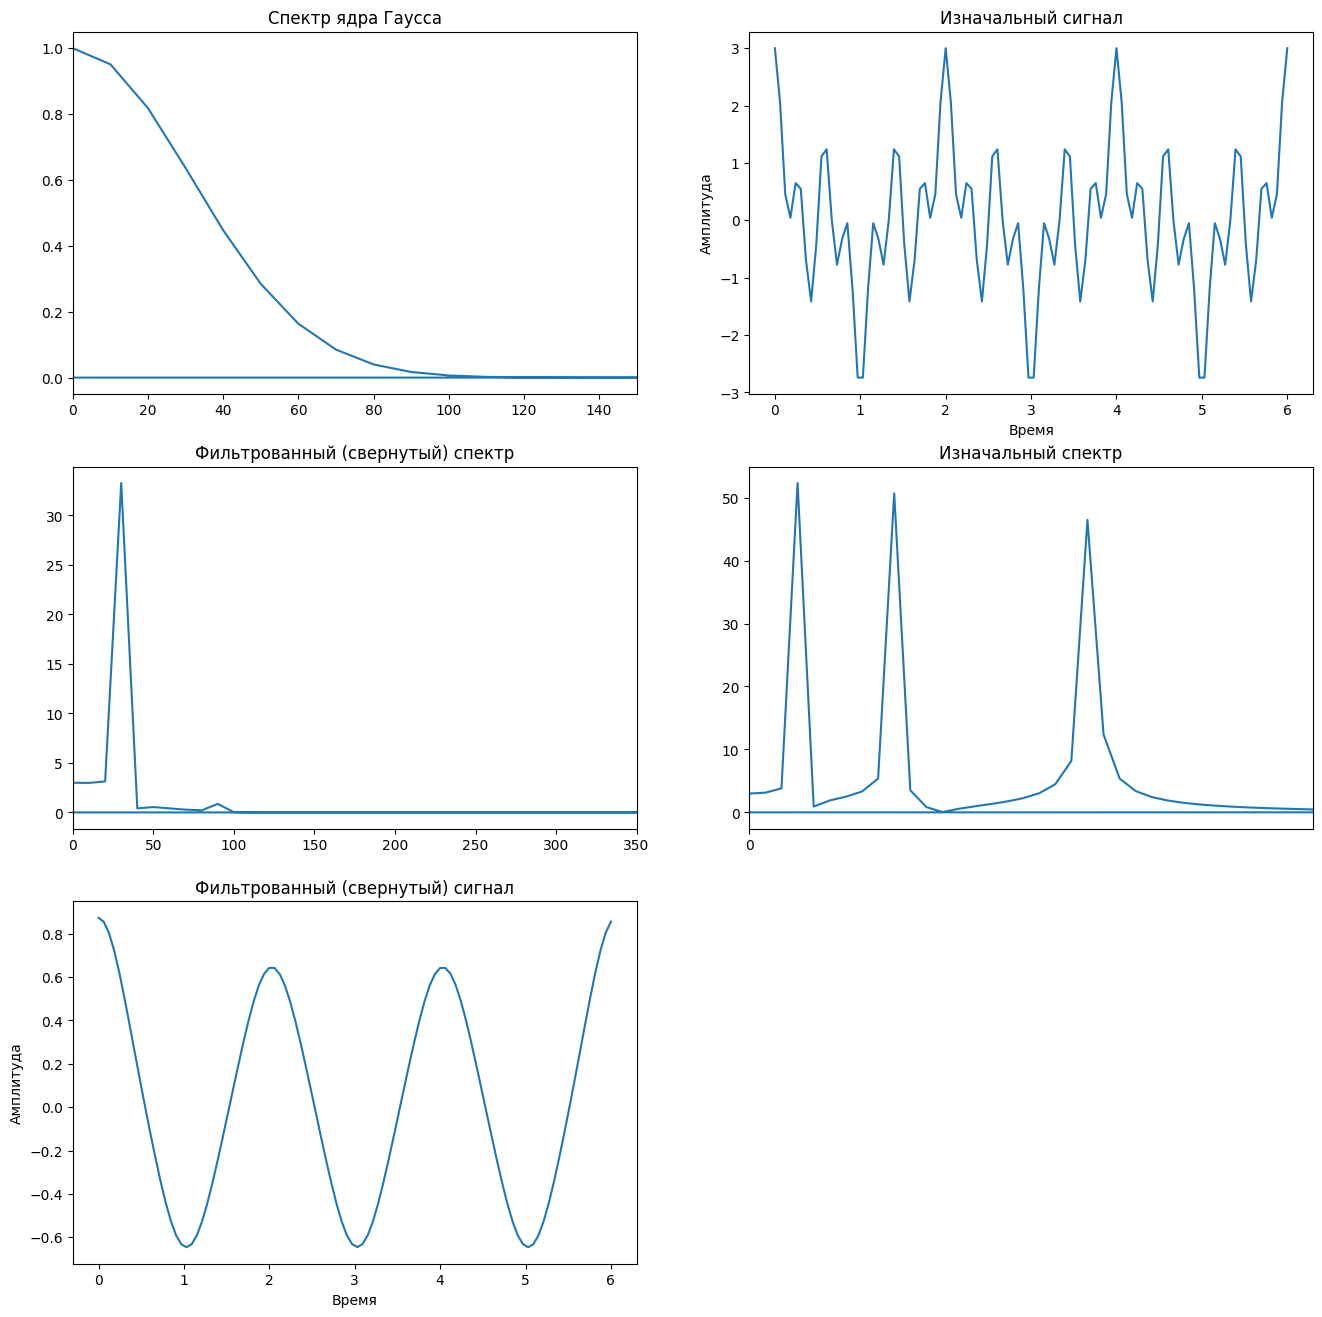

In [23]:
def gaussian_frequency_kernel(frequencies, peak_frequency, FWHM):
    s = (FWHM * (2 * np.pi - 1)) / (4 * np.pi)
    kernel = np.exp(-0.5 * ((frequencies - peak_frequency) / s) ** 2)
    return kernel

sample_rate = 1000
peak_frequency = 0 # target freq
FWHM = 75  # width

# Создаем частотный массив
frequencies = np.fft.fftfreq(len(cos_sum_time), 1.0 / sample_rate)

frequency_kernel = gaussian_frequency_kernel(frequencies, peak_frequency, FWHM)

spectrum_cos_sum = np.abs(np.fft.fft(cos_sum_vals))
conved_cos_sum = frequency_kernel * spectrum_cos_sum

plt.figure(figsize=(16, 16))

plt.subplot(321)
plt.plot(frequencies, np.abs(frequency_kernel))
plt.title('Cпектр ядра Гаусса')
plt.xlim([0, 150])

plt.subplot(322)
plt.title("Изначальный сигнал")
plt.plot(cos_sum_time, cos_sum_vals)
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.subplot(323)
plt.title("Фильтрованный (свернутый) спектр")
plt.plot(frequencies, conved_cos_sum)
plt.xlim([0, 350])

plt.subplot(324)
plt.title("Изначальный спектр")
plt.plot(frequencies, np.abs(np.fft.fft(cos_sum_vals)))
plt.xticks([0])
plt.xlim([0, 350])

plt.subplot(325)
plt.title("Фильтрованный (свернутый) сигнал")
plt.plot(cos_sum_time, np.fft.ifft(conved_cos_sum))
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.show()


## Окно Планка

In [24]:
def a(k, eps, N):
    za = lambda k, eps, N: eps * (N - 1) * (1 / k + 1 / (k - eps * (N - 1)))
    zb = lambda k, eps, N: eps * (N - 1) * (1 / (N - 1 - k) + 1 / (-k + (1 - eps) * (N - 1)))

    if k == 0 or k == N - 1:     return 0
    if k < eps * (N - 1):        return 1 / (np.exp(za(k, eps, N)) + 1)
    if k <= (1 - eps) * (N - 1): return 1
    if k < N - 1:                return 1 / (np.exp(zb(k, eps, N)) + 1)
    return 0

def plank(eps, fwhm, m_len=200):
    plank = [a(k, eps, fwhm) for k in range(fwhm)]
    return np.pad(plank, (0, m_len-len(plank)))

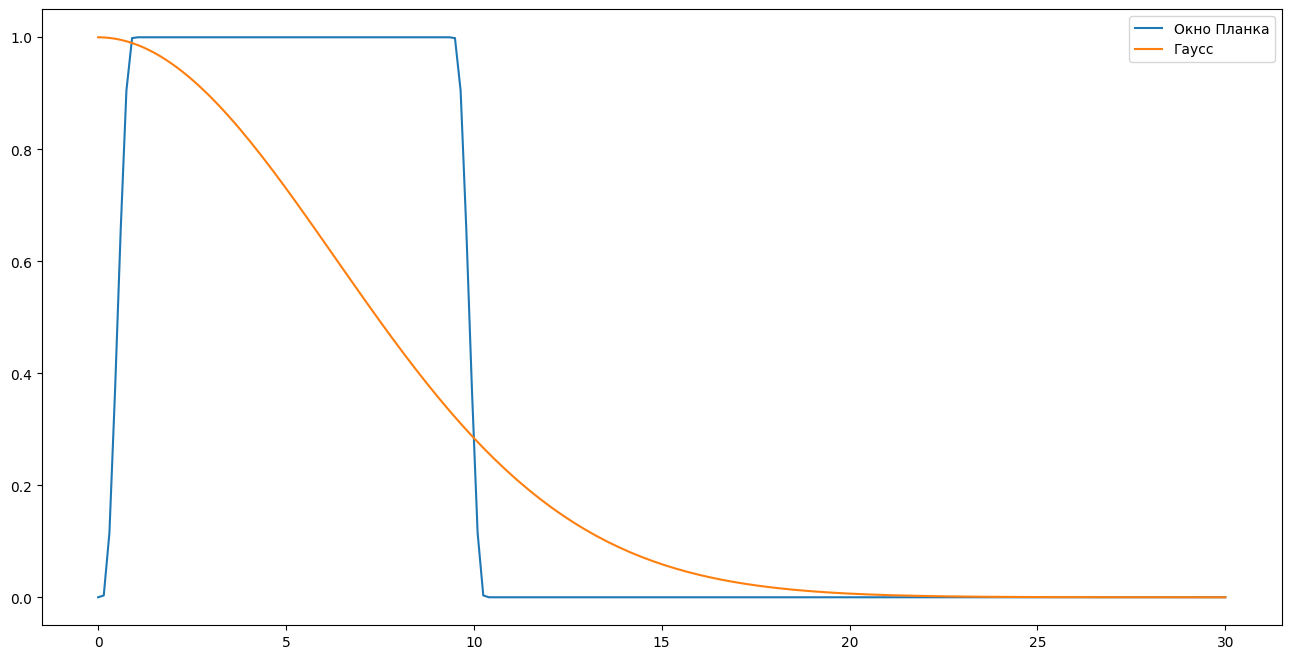

In [25]:
planka = plank(0.1,70)
frequencies = np.linspace(0, 30, 200)
peak_frequency = 0 # target freq
FWHM = 15  # width
gaus_freqs = gaussian_frequency_kernel(frequencies, peak_frequency, FWHM)

fig = plt.figure(figsize=(16,8))
plt.plot(frequencies, planka, label="Окно Планка")
plt.plot(frequencies, gaus_freqs, label="Гаусс")
plt.legend()
plt.show()

## Зашумленный (Планк/Гаусс)

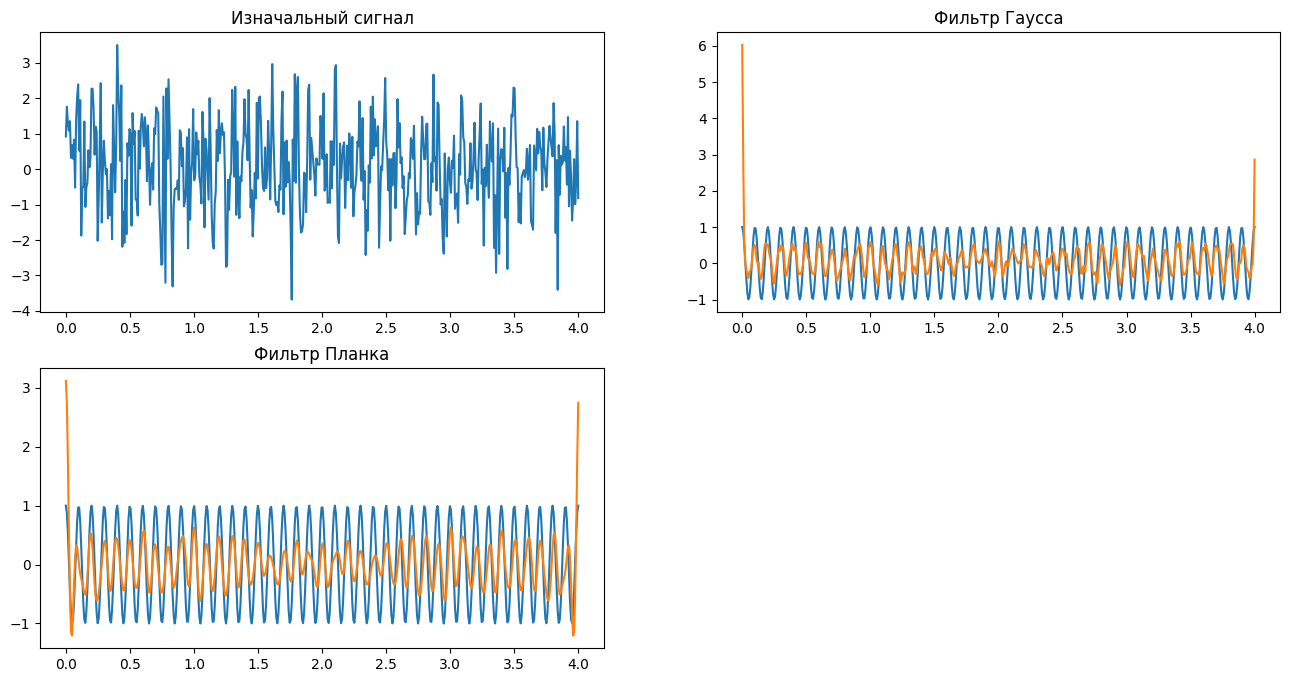

In [26]:
samples_rate = 500

frequencies = np.linspace(0, 30, samples_rate)
planka = plank(0.1,70, samples_rate)

peak_frequency = 0 # target freq
FWHM = 15  # width
gaus_freqs = gaussian_frequency_kernel(frequencies, peak_frequency, FWHM)

cos_noised = cosinus_signal_func(freq=10)
cos_noised_vals, cos_noised_time = calc_signal(cos_noised, t_end=4, steps_cnt=samples_rate, noised=True)
cos_vals, cos_time = calc_signal(cos_noised, t_end=4, steps_cnt=samples_rate)

spectrum_cos_signal = np.abs(np.fft.fft(cos_noised_vals))
gaus_filtered  = np.fft.ifft(gaus_freqs * spectrum_cos_signal)
plank_filtered = np.fft.ifft(planka * spectrum_cos_signal)

plt.figure(figsize=(16, 8))

plt.subplot(221)
plt.plot(cos_noised_time, cos_noised_vals)
plt.title('Изначальный сигнал')

plt.subplot(222)
plt.plot(cos_noised_time, cos_vals)
plt.plot(cos_noised_time, gaus_filtered)
plt.title('Фильтр Гаусса')

plt.subplot(223)
plt.plot(cos_noised_time, cos_vals)
plt.plot(cos_noised_time, plank_filtered)
plt.title('Фильтр Планка')

plt.show()